Projeto Final Linguagens de Programação para Machine Learning, Bootcamp Dio e BairesDev

Implementar TransferLearning

**Oque é Tranfer Learning** = Transfer Learning (ou Aprendizado por Transferência) é uma técnica de Aprendizado de Máquina em que um modelo já treinado em uma tarefa é reaproveitado para outra tarefa, em vez de treinar tudo do zero.



In [ ]:
#Requisitos
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import os
from PIL import Image
import urllib.request
from zipfile import ZipFile
import zipfile


In [ ]:

dest_folder = '/content/Images' #Cria um diretorio
os.makedirs(dest_folder, exist_ok=True)

#Url do dataset
url = "https://download.microsoft.com/download/3/e/1/3e1c3f21-ecdb-4869-8368-6deba77b919f/kagglecatsanddogs_5340.zip"

filename = os.path.join(dest_folder,"catsdogs.zip")

# Download
urllib.request.urlretrieve(url, filename)

print(f'Download concluído: {filename}')


Download concluído: /content/Images/catsdogs.zip


In [ ]:
!ls /content/Images


catsdogs.zip


verificar se o zip esta dentro da pasta correta

In [ ]:
#utilizado para extrair o conteudo da pasta compactada


zip_path = "/content/Images/catsdogs.zip"
extract_to = "/content/images_data"


if(os.path.exists(zip_path)): #verifica se existe o caminho
 if(zipfile.is_zipfile(zip_path)): #verifica se o arquivo é zip
   with ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        print("Arquivo descompactado")
 else:
    print("Arquivo não é zip")
else:
  print("Arquivo não encontrado")



✅ Arquivo descompactado com sucesso!


In [ ]:

def is_valid_image(path):# Verifica se a imagem é válida

    try:
        with Image.open(path) as img: #abre a imagem e verifica totalmente se ela esta correta
            img.convert('RGB').load()

        image = tf.io.read_file(path) #usa o tensorflow para verificar se a imagem esta correta
        tf.image.decode_jpeg(image)

        if(os.path.getsize(path) == 0): #verifica se não esta vazio
          raise Exception("Arquivo vazio")

        if(not filename.lower().endswith(('.jpg', '.jpeg', '.png'))): #verifica se o formato é permitido
          raise Exception("Formato de arquivo não suportado")

        return True
    except Exception:
        return False



no_valid_images = [] #imagens que nao estão validas
pastas = ['/content/images_data/PetImages/Cat','/content/images_data/PetImages/Dog'] # as duas classes usadas


for pasta in pastas: #percorre as duas pastas
  for filename in os.listdir(pasta): #percorre os arquivos da pasta
    filepath = os.path.join(pasta, filename) # junta o nome do arquivo com o nome da pasta
    if (is_valid_image(filepath)) == False :
        no_valid_images.append(filepath) # se a imagem não for valida,seu caminho é guardada


for path in no_valid_images:
    try:
        os.remove(path) #remove quaisquer imagens invalidas

    except Exception as e:
        print(f"Erro ao remover {path}: {e}")

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [ ]:
#fazer remoção boa de corrompidos antes

#Caminho para o Dataset
dataset_path = "/content/images_data/PetImages"

#dividir o Dataset em treino e validação
train_dataset = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed = 123,
    image_size=(224, 224),
    batch_size=32
)
#usando 20% para validação
val_dataset = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed = 123,
    image_size=(224, 224),
    batch_size=32
)

Found 24824 files belonging to 2 classes.
Using 19860 files for training.
Found 24824 files belonging to 2 classes.
Using 4964 files for validation.


In [ ]:
#modelo escolhido
model_efficient = EfficientNetB0(weights='imagenet',include_top = False,input_shape=(224,224,3))#weights='imagenet' : usa os pesos do imagenet
                                                                                                #include_top = False : é utilizado para retreinar o modelo para outras classes
                                                                                                #input_shape=(224,224,3) : entrada de imagens RGB 224x224
model_efficient.trainable = False
#Congela todas as camadas do modelo, impedindo que seus pesos sejam atualizados durante o treinamento.
#Usado para transformar o modelo pré-treinado em apenas um extrator de caracteristicas,e treinar apenas as novas camadas que você adicionou no final

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from ast import Mod

Model_efficient = Sequential([
    model_efficient,                #Modelo pré-treinado
    GlobalAveragePooling2D(),       #Reduz o mapa de características para um vetor
    Dense(128,activation='relu'),   #Camada densa para aprender padrões específicos da sua base
    Dense(2,activation='softmax')   #Saída final com 2 classes (softmax)
])

Model_efficient.compile(
    optimizer='adam',               #Quem esta fazendo o calculo dos pesos
    loss='sparse_categorical_crossentropy',#Função de perda
    metrics=['accuracy']                   #Mostra a acuracia durenate o treino
)


In [ ]:
historyEfficient = Model_efficient.fit(train_dataset,validation_data=val_dataset,epochs=5)
#Mostra os passos durante o treino

Epoch 1/5
621/621 ━━━━━━━━━━━━━━━━━━━━ 958s 2s/step - accuracy: 0.9830 - loss: 0.0499 - val_accuracy: 0.9879 - val_loss: 0.0310
Epoch 2/5
621/621 ━━━━━━━━━━━━━━━━━━━━ 1011s 2s/step - accuracy: 0.9933 - loss: 0.0191 - val_accuracy: 0.9919 - val_loss: 0.0237
Epoch 3/5
621/621 ━━━━━━━━━━━━━━━━━━━━ 963s 2s/step - accuracy: 0.9962 - loss: 0.0120 - val_accuracy: 0.9919 - val_loss: 0.0242
Epoch 4/5
621/621 ━━━━━━━━━━━━━━━━━━━━ 976s 2s/step - accuracy: 0.9969 - loss: 0.0101 - val_accuracy: 0.9905 - val_loss: 0.0266
Epoch 5/5
621/621 ━━━━━━━━━━━━━━━━━━━━ 961s 2s/step - accuracy: 0.9975 - loss: 0.0079 - val_accuracy: 0.9913 - val_loss: 0.0300


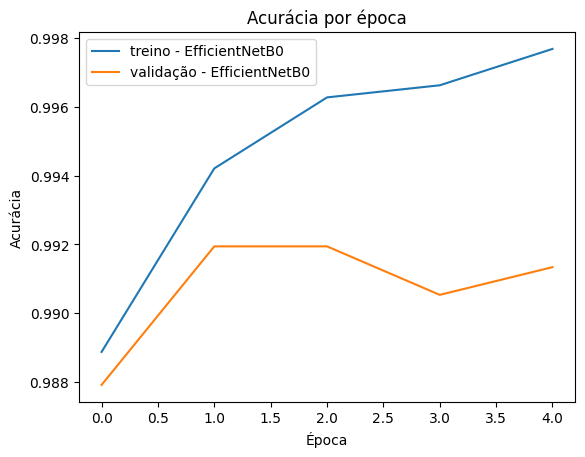

In [ ]:
plt.plot(historyEfficient.history['accuracy'],label='treino - EfficientNetB0') #Plota a acuracia no treino
plt.plot(historyEfficient.history['val_accuracy'],label='validação - EfficientNetB0')#Plota a acuracia na validação
plt.legend()
plt.title("Acurácia por época")
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.show()


In [ ]:
def avaliar_modelo(model,val_dataset,nome_modelo):
  y_true = np.concatenate([y for x, y in val_dataset], axis=0) #concatena os rotulos de cada batch
  y_pred = np.argmax(model.predict(val_dataset),axis=1) #junta as classes previstas para cada amostra da val_dataset

  cm = confusion_matrix(y_true,y_pred) #monta a matrix de confusão
  print("Relatorio - f{nome_modelo}")
  print(classification_report(y_true,y_pred,target_names=["Cat", "Dog"])) #Printa a classificação do modelo

  plt.figure(figsize=(8,8))
  plt.imshow(cm,cmap=plt.cm.Blues)
  plt.title(f"Matriz de confusão - {nome_modelo}")
  plt.colorbar()
  plt.xticks([0,1],["Cat","Dog"])
  plt.yticks([0,1],["Cat","Dog"])

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], ha='center', va='center')

  plt.xlabel("Predito")
  plt.ylabel("Verdadeiro")
  plt.tight_layout()
  plt.show()

156/156 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step
Relatorio - f{nome_modelo}
              precision    recall  f1-score   support

         Cat       0.49      0.50      0.50      2431
         Dog       0.51      0.51      0.51      2533

    accuracy                           0.50      4964
   macro avg       0.50      0.50      0.50      4964
weighted avg       0.50      0.50      0.50      4964



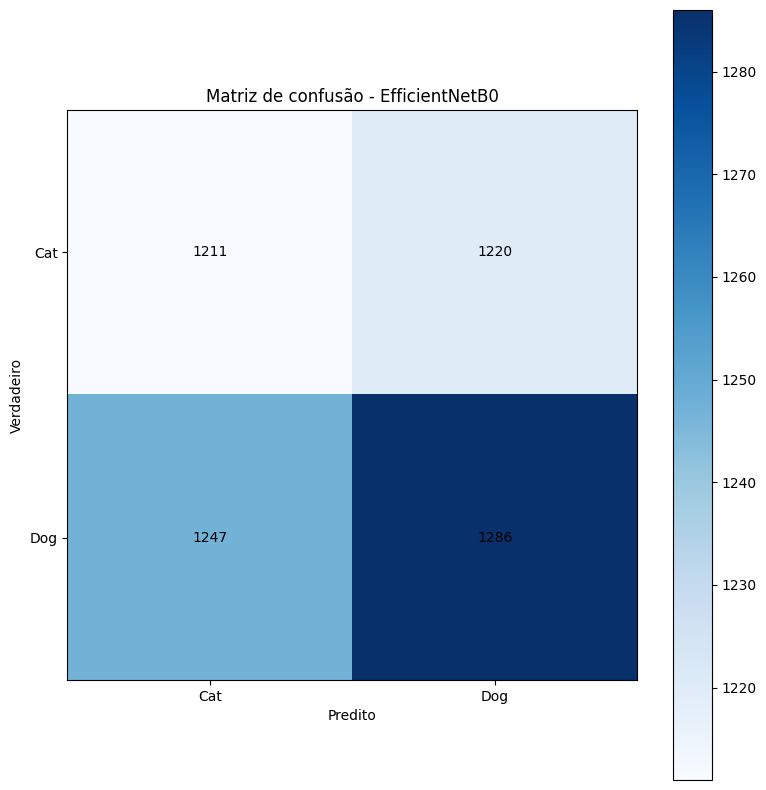

In [ ]:
avaliar_modelo(Model_efficient,val_dataset,"EfficientNetB0")
